In [1]:
import matplotlib.pyplot as plt
import torchvision
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time
import os 

/home/zyliu/miniconda3/envs/pytorch/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
                 datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
                 transforms.RandomHorizontalFlip(),
                 transforms.RandomCrop(32, 4),
                 transforms.ToTensor(),
                 normalize,
                 ]), download=True),
                 batch_size=256, shuffle=True,
                 num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
               datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
               transforms.ToTensor(),
               normalize,
               ])),
               batch_size=256, shuffle=False,
               num_workers=4, pin_memory=True)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.conv3 = nn.Conv2d(out_channel, self.expansion *
                               out_channel, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*out_channel)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channel != self.expansion*out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion*out_channel,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 128

        self.conv1 = nn.Conv2d(3, 128, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)
        # self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion*4, num_classes)
        # self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        # out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
def project1_model():
    return ResNet(Bottleneck, [2, 3, 3, 2])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = project1_model().to(device)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,456
       BatchNorm2d-2          [-1, 128, 32, 32]             256
            Conv2d-3          [-1, 128, 32, 32]          16,384
       BatchNorm2d-4          [-1, 128, 32, 32]             256
            Conv2d-5          [-1, 128, 16, 16]         147,456
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 512, 16, 16]          65,536
       BatchNorm2d-8          [-1, 512, 16, 16]           1,024
            Conv2d-9          [-1, 512, 16, 16]          65,536
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
       Bottleneck-11          [-1, 512, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]          65,536
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 128,

In [7]:
class ResNetParams:
   """
    A class to pass the hyperparameters to the model
   """
   def __init__(self, arch='Model 1' ,epochs=100, start_epoch=0, batch_size=256, lr=0.1, momentum=0.9, weight_decay=1e-4, print_freq=50,
                save_dir='save_temporary_checkpoints', save_every=10):
        self.save_every = save_every #Saves checkpoints at every specified number of epochs
        self.save_dir = save_dir #The directory used to save the trained models
        self.print_freq = print_freq #print frequency 
        self.weight_decay = weight_decay #Weight decay for SGD
        self.momentum = momentum #Momentum for SGD
        self.lr = lr #Learning Rate
        self.batch_size = batch_size #Batch Size for each epoch 
        self.start_epoch = start_epoch #Starting Epoch
        self.epochs = epochs #Total Epochs
        self.arch = arch #ResNet model name

In [8]:
def run_epochs():
    global args, best_precision
    #Check if the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    #Loading the model 
    model = project1_model()
    model.cuda()

    #Defining the Loss Function
    loss_func = nn.CrossEntropyLoss().cuda()

    #Defining the Optimizer
    # optimizer = torch.optim.SGD(model.parameters(), args.lr,
    #                             momentum=args.momentum,
    #                             weight_decay=args.weight_decay)
    optimizer = torch.optim.Adam(model.parameters(), args.lr, betas=(0.9, 0.99))
    
    #Defining the Learning Rate Scheduler
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                        milestones=[100, 150], last_epoch=args.start_epoch - 1)

    for epoch in range(args.start_epoch, args.epochs):
        #Train for one epoch
        print('Training model: {}'.format(args.arch))
        print('Current Learning Rate {:.5e}'.format(optimizer.param_groups[0]['lr']))
        train(train_loader, model, loss_func, optimizer, epoch)
        lr_scheduler.step()

        #Test for one epoch
        precision = validate(val_loader, model, loss_func)

        #Save the best precision and make a checkpoint
        is_best = precision > best_precision
        best_precision = max(precision, best_precision)
        if epoch > 0 and epoch % args.save_every == 0:
            torch.save(model.state_dict(), os.path.join(args.save_dir, 'project1_model_checkpoint.th'))
        if is_best:
            torch.save(model.state_dict(), os.path.join(args.save_dir, 'project1_model.th'))
    return best_precision

In [9]:
class KeepAverages(object):
    #Computes and stores the average along with the current value
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def accuracy(output, target, topk=(1,)):
    #Computes the top 1 precision
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def validate(val_loader, model, loss_func):
    #Run an Evaluation
    batch_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    #Switch to Evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            #Compute the output of the Model and calculate the Loss
            output = model(input_var)
            loss = loss_func(output, target_var)
            output = output.float()
            loss = loss.float()

            #Measure the Loss and Update it 
            precision = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(precision.item(), input.size(0))

            #Measure the elapsed time
            batch_time.update(time.time() - end)
            end = time.time()


    print('Test Accuracy\t  Top Precision: {top1.avg:.3f} (Error: {error:.3f} )\n'
          .format(top1=top1,error=100-top1.avg))
    val_losses.append(100-top1.avg)
    return top1.avg

In [11]:
def train(train_loader, model, loss_func, optimizer, epoch):
    #Run one training epoch

    batch_time = KeepAverages()
    data_time = KeepAverages()
    losses = KeepAverages()
    top1 = KeepAverages()

    #Switch to Train mode
    model.train()
    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # Measure the data loading time
        data_time.update(time.time() - end)
        target = target.cuda()
        input_var = input.cuda()
        target_var = target

        #Compute the output and the Loss
        output = model(input_var)
        loss = loss_func(output, target_var)

        #Compute the Gradient and do an SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        output = output.float()
        loss = loss.float()
        
        #Measure the accuracy and record the loss
        precision = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(precision.item(), input.size(0))

        #Measure the Elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: No: [{0}] Batches: [{1}/{2}]\t'
                  'Loss: {loss.val:.4f} (Average: {loss.avg:.4f})\t'
                  'Precision: {top1.val:.3f} (Average: {top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    train_losses.append(100-top1.val)

In [12]:
def imshow(img):
  #Function to show an image
  %matplotlib inline
  %config InlineBackend.figure_format = 'retina'
  img = img / 2 + 0.5     # un - Normalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [13]:
args=ResNetParams()
val_losses = []
train_losses = []
best_precision = 0
best_precision = run_epochs()
print('The lowest error from model: {} after {} epochs is {error:.3f}'.format(args.arch,args.epochs, error=100-best_precision))
model_save_name = 'project1_model.pt'
#path = F"/content/gdrive/My Drive/{model_save_name}" 

#Saving the generated model and testing its loading
path = model_save_name
torch.save(model.state_dict(), path) 
model_path = path
model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

Training model: Model 1
Current Learning Rate 1.00000e-01
Epoch: No: [0] Batches: [0/196]	Loss: 2.4132 (Average: 2.4132)	Precision: 5.859 (Average: 5.859)
Epoch: No: [0] Batches: [50/196]	Loss: 2.3068 (Average: 17.5647)	Precision: 8.984 (Average: 10.585)
Epoch: No: [0] Batches: [100/196]	Loss: 2.2000 (Average: 9.9843)	Precision: 20.312 (Average: 12.488)
Epoch: No: [0] Batches: [150/196]	Loss: 2.0955 (Average: 7.3808)	Precision: 21.484 (Average: 14.994)
Test Accuracy	  Top Precision: 23.330 (Error: 76.670 )

Training model: Model 1
Current Learning Rate 1.00000e-01
Epoch: No: [1] Batches: [0/196]	Loss: 2.0013 (Average: 2.0013)	Precision: 22.656 (Average: 22.656)
Epoch: No: [1] Batches: [50/196]	Loss: 1.9208 (Average: 2.0065)	Precision: 24.219 (Average: 24.701)
Epoch: No: [1] Batches: [100/196]	Loss: 1.7963 (Average: 1.9777)	Precision: 32.031 (Average: 25.789)
Epoch: No: [1] Batches: [150/196]	Loss: 1.8900 (Average: 1.9476)	Precision: 28.516 (Average: 26.681)
Test Accuracy	  Top Precisio

<All keys matched successfully>

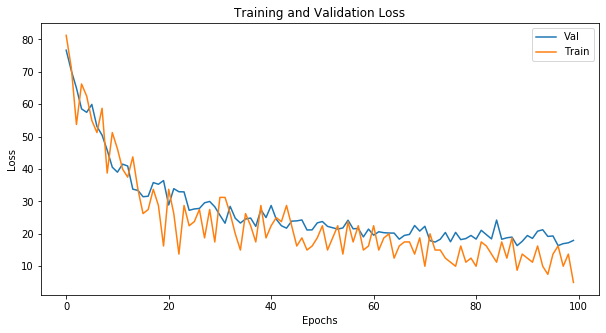

<Figure size 432x288 with 0 Axes>

In [14]:
#Plotting the model
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="Val")
plt.plot(train_losses,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('plot_graph.png')